# Load dependencies and define file paths

In [1]:
import os
import glob
from pprint import pprint
import json
import pickle
import re
from collections import OrderedDict
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import display

In [2]:
from Bio import SeqIO
from rdkit import Chem as chem
from rdkit.Chem import AllChem, Draw, rdFMCS
from rdkit.Chem.Draw import IPythonConsole

In [3]:
import imp
helper = imp.load_source('helper', './pks/helper.py')
domain = imp.load_source('domain', './pks/domain.py')
pks = imp.load_source('pks', './pks/pks.py')

# Description of available clusters

In [4]:
# Load parsed clusters from pickle file
raw_clusters = pickle.load(open("pruned_clusters_mibig.p", "rb" ))

# Show clusters available
print('%d clusters available!' %(len(raw_clusters)))
# Get starter and extender units represented in set of clusters
starter_units = []
extender_units = []

# Get compound names to try to match structures
compound_to_accession = {}
accession_to_compound = {}

# Get number of modules represented in set of clusters
nmodules = 0
for accession,cluster in raw_clusters.items():
    print(cluster.description)
    compound_name = cluster.description.split()[0].lower().strip()
    if compound_name in compound_to_accession.keys():
        compound_to_accession[compound_name].append(accession)
    else:
        compound_to_accession[compound_name] = [accession]
    accession_to_compound[accession] = compound_name
    # Get subunits
    subunits = cluster.subunits
    for subunit in subunits.values():
        nmodules += len(subunit.modules)
        for module in subunit.modules:
            if module.loading == True:
                starter_units.append(module.domains['AT'][1]['Substrate specificity predictions'].split()[0])
            else:
                extender_units.append(module.domains['AT'][1]['Substrate specificity predictions'].split()[0])
print('%d modules available!' %(nmodules))
print('Starter units: %s' %(set(starter_units)))
print('Extender units: %s' %(set(extender_units)))

151 clusters available!
Crocacin biosynthetic gene cluster
Chondramide biosynthetic gene cluster
Geldanamycin biosynthetic gene cluster
Ebelactone biosynthetic gene cluster
FD-891 biosynthetic gene cluster
Angolamycin biosynthetic gene cluster
Marineosin biosynthetic gene cluster
Epothilone biosynthetic gene cluster
Maklamicin biosynthetic gene cluster
Myxothiazol biosynthetic gene cluster
Streptolydigin biosynthetic gene cluster
Tylactone biosynthetic gene cluster
Gulmirecin biosynthetic gene cluster
FR-008 biosynthetic gene cluster
Epoxomicin biosynthetic gene cluster
Pyrrolomycin biosynthetic gene cluster
Pyoluteorin biosynthetic gene cluster
Mycobactin biosynthetic gene cluster
Lobophorin biosynthetic gene cluster
Puwainaphycins biosynthetic gene cluster
Bleomycin biosynthetic gene cluster
Marinopyrrole biosynthetic gene cluster
Filipin biosynthetic gene cluster
Pyoluteorin biosynthetic gene cluster
Calcimycin biosynthetic gene cluster
Naphthomycin biosynthetic gene cluster
Colibac

In [5]:
print(set(starter_units))
print(set(extender_units))

{'trans-1,2-CPDA', 'cemal', 'isobut', 'mal', '2metbut', 'CHC-CoA', 'prop', 'N/A', 'mmal', 'mxmal'}
{'emal', 'mmal', 'N/A', 'mal', 'mxmal'}


In [6]:
# Exclude clusters if they have only one module
def module_count(cluster):
    count = 0
    for subunit in cluster.subunits.values():
        count += len(subunit.modules)
    return count

clusters = {}
excluded_clusters = {}

for key,cluster in raw_clusters.items():
    if module_count(cluster) > 2:
        clusters[key] = cluster
    else:
        excluded_clusters[key] = cluster

In [7]:
# These are clusters that have at least 3 modules
print('%d Clusters available!' %(len(clusters.keys())))
for accession,cluster in clusters.items():
    print(cluster.description)

109 Clusters available!
Crocacin biosynthetic gene cluster
Chondramide biosynthetic gene cluster
Sanglifehrin A biosynthetic gene cluster
Thuggacin biosynthetic gene cluster
FD-891 biosynthetic gene cluster
Angolamycin biosynthetic gene cluster
Macbecin biosynthetic gene cluster
Incednine biosynthetic gene cluster
Maklamicin biosynthetic gene cluster
Myxothiazol biosynthetic gene cluster
Streptolydigin biosynthetic gene cluster
Gulmirecin biosynthetic gene cluster
Aldgamycin biosynthetic gene cluster
Cylindrospermopsin biosynthetic gene cluster
Candicidin biosynthetic gene cluster
Lobophorin biosynthetic gene cluster
Tautomycin biosynthetic gene cluster
Filipin biosynthetic gene cluster
Dihydrochalcomycin biosynthetic gene cluster
Calcimycin biosynthetic gene cluster
Naphthomycin biosynthetic gene cluster
Lankamycin biosynthetic gene cluster
Meridamycin biosynthetic gene cluster
Natamycin biosynthetic gene cluster
Ansamitocin biosynthetic gene cluster
Nemadectin biosynthetic gene clust

In [8]:
# These are clusters that lack the minimum of 3 modules
print('%d Clusters excluded!' %(len(excluded_clusters.keys())))
for accession,cluster in excluded_clusters.items():
    print(cluster.description)

42 Clusters excluded!
Tubulysin biosynthetic gene cluster
Pactamycin biosynthetic gene cluster
Salinosporamide A biosynthetic gene cluster
Undecylprodigiosin biosynthetic gene cluster
Tallysomycin biosynthetic gene cluster
Geldanamycin biosynthetic gene cluster
Salinomycin biosynthetic gene cluster
Syringolin A biosynthetic gene cluster
Eponemycin biosynthetic gene cluster
Thiotetroamide biosynthetic gene cluster
Marineosin biosynthetic gene cluster
Microsclerodermins biosynthetic gene cluster
Kendomycin biosynthetic gene cluster
Pyridomycin biosynthetic gene cluster
Jawsamycin biosynthetic gene cluster
Bleomycin biosynthetic gene cluster
Cinnabaramide biosynthetic gene cluster
Zeamine biosynthetic gene cluster
Pyrrolomycin biosynthetic gene cluster
Pyoluteorin biosynthetic gene cluster
U-68204 biosynthetic gene cluster
Rimocidin biosynthetic gene cluster
Epoxomicin biosynthetic gene cluster
Mycobactin biosynthetic gene cluster
Microsclerodermins biosynthetic gene cluster
Microcystin b

# Are there important clusters that were excluded because they lack the requisite number of modules? 

# Note that some clusters, such as calcheamicin, actually  just have poor antiSMASH annotations. We don't plan to do anything about those at this time, so we only want to go back and check the quality of the antiSMASH annotations "by hand" if the cluster is deemed very important/well characterized.

# Known structures from MiBiG from JSON files and from ChemAxon

In [9]:
# Import and parse structures from JSON files
mibigFolder = "mibig/"
jsonFiles = list(filter(re.compile("^\w+.*\.json$").match, os.listdir(mibigFolder)))

# This dictionary will have key = accession number, value = RDKit mol object (final product)
geneClusters = {}

# This dictionary will have key = compound name, value = SMILES structure (final product)
json_compounds = {}

for jsonFile in jsonFiles:
    accession = re.search('^\w+', jsonFile).group(0).strip()
    clusterFile = open(mibigFolder + jsonFile).read()
    pksData = json.loads(clusterFile)
    try:
        structures = [x['chem_struct'] for x in pksData['general_params']['compounds']]
    except KeyError:
        continue
    molStructures = [chem.MolFromSmiles(structure) for structure in structures]
    geneClusters[accession] = molStructures
    # Add to JSON compounds
    try:
        json_compounds[accession_to_compound[accession]] = structures
    except KeyError:
        continue

In [10]:
print([len(compounds) for compounds in json_compounds.values()])

[1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 4, 1, 1, 5, 1, 2, 1, 1, 1, 1, 5, 2, 1, 1]


In [11]:
# Import and parse mibig structures from ChemAxon predictions
with open('./mibig_compounds.smi') as f:
    raw_compounds = [line.split() for line in f.readlines()]

# Process into dictionary, ignoring duplicates
# defined as compounds with '_' which will remove some legitimate
# compounds but we can do a manual check to get them afterwards if needed

# This dictionary will have key = compound name, value = SMILES structure (final product)
mibig_compounds = {}
for raw_compound in raw_compounds:
    structure = raw_compound[0]
    name = raw_compound[1]
    if len(name.split('_')) == 1:
        mibig_compounds[name] = structure

In [12]:
# This just uses incorporates the structures predicted using ChemAxon into geneClusters
# then we can just continue with the compound comparison as before
nstruct_from_json = len(geneClusters.keys())

# Let's just go through the accessions
for accession,compound in accession_to_compound.items():
    # This is checking if we already have a product for the cluster
    if accession not in geneClusters.keys():
        if compound in mibig_compounds.keys():
            structure = mibig_compounds[compound] # this is a string
            molStructure = chem.MolFromSmiles(structure)
            geneClusters[accession] = [molStructure]
        elif compound in json_compounds.keys():
            structures = json_compounds[compound] # this is a list
            molStructures = [chem.MolFromSmiles(structure) for structure in structures]
            geneClusters[accession] = molStructures
        else:
            continue
nstruct_from_both = len(geneClusters.keys())
print('Incorporated ChemAxon predictions to go from %d to %d known structures.' %(nstruct_from_json, nstruct_from_both))

Incorporated ChemAxon predictions to go from 200 to 250 known structures.


In [13]:
# Import and parse manually assembled structures
nstruct_before_manual = len(geneClusters.keys())

with open('./orphan_compounds.smi') as f:
    raw_orphans = [line.split() for line in f.readlines()]

for orphan_compound in raw_orphans:
    structure = orphan_compound[-1].strip()
    accession = orphan_compound[-2].strip()
    geneClusters[accession] = [chem.MolFromSmiles(structure)]
    
nstruct_after_manual = len(geneClusters.keys())
print('Incorporated manual predictions to go from %d to %d known structures.' %(nstruct_before_manual, nstruct_after_manual))

Incorporated manual predictions to go from 250 to 254 known structures.


# Get predicted clusters

# Intersection between predicted and known structures

RDKit ERROR: [21:59:54] Explicit valence for atom # 2 O, 3, is greater than permitted


Valid structures: 107


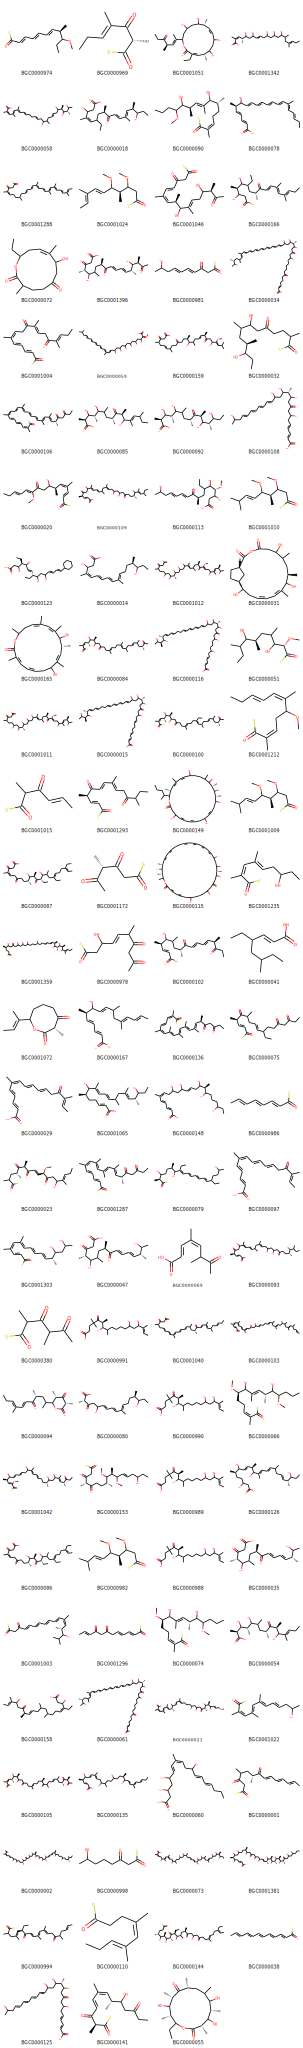

In [14]:
# Compute and plot predicted final product structures
def getProduct(cluster):
    try:
        m = cluster.compute_product(None)
    except:
        return(False)
    return(m)
finalStructures = {key: getProduct(cluster) for key,cluster in clusters.items()}
finalStructures = {re.search('^\w+', key).group(0): cluster for key, cluster in finalStructures.items() if cluster}
print("Valid structures: " + str(len(finalStructures.keys())))
Draw.MolsToGridImage(list(finalStructures.values()), legends=list(finalStructures.keys()), molsPerRow=4, useSVG=True)

In [15]:
# Intersection of predicted and annotated structures
geneClusterIntersect = list(set(geneClusters.keys()).intersection(set(finalStructures.keys())))
print("Clusters with known final structures in MiBiG: " + str(len(geneClusterIntersect)))

Clusters with known final structures in MiBiG: 67


# Clusters excluded because of missing final structures

In [16]:
# These are the clusters that were rejected because they lack structures in the JSON files AND ChemAxon predictions
counter = 0
for accession,cluster in clusters.items():    
    if accession not in geneClusterIntersect: 
        print('%d: %s %s' %(counter, accession, cluster.description))
        counter += 1

0: BGC0000974 Crocacin biosynthetic gene cluster
1: BGC0001042 Sanglifehrin A biosynthetic gene cluster
2: BGC0000058 FD-891 biosynthetic gene cluster
3: BGC0000018 Angolamycin biosynthetic gene cluster
4: BGC0000078 Incednine biosynthetic gene cluster
5: BGC0001396 Aldgamycin biosynthetic gene cluster
6: BGC0001004 Lobophorin biosynthetic gene cluster
7: BGC0000047 Dihydrochalcomycin biosynthetic gene cluster
8: BGC0000106 Naphthomycin biosynthetic gene cluster
9: BGC0000020 Ansamitocin biosynthetic gene cluster
10: BGC0000123 Phoslactomycin B biosynthetic gene cluster
11: BGC0000165 Tiacumicin B biosynthetic gene cluster
12: BGC0000042 Cremimycin biosynthetic gene cluster
13: BGC0000051 Ebelactone biosynthetic gene cluster
14: BGC0001303 Lobosamide biosynthetic gene cluster
15: BGC0001293 Cyclizidine biosynthetic gene cluster
16: BGC0000126 Pladienolide biosynthetic gene cluster
17: BGC0000147 Soraphen biosynthetic gene cluster
18: BGC0000102 Mycinamicin biosynthetic gene cluster
19:

# The PKSs predicted from the antiSMASH annotations from the above clusters have at least 3 modules (the predicted final products for all of the clusters are shown above). Would it be possible for you to find the real structures and send them to me? Please use the format "BGC0000001 SMILES_STRUCTURE" with each entry on a new line.

In [17]:
# Compute MCS for every cluster with a known final product
def getMCS(geneClusterName, finalStructures = finalStructures, geneClusters = geneClusters):
    predicted = finalStructures[geneClusterName]
    known = geneClusters[geneClusterName]
    # If geneCluster has multiple predicted products, keep only the one with the largest MCS
    size = 0
    for structure in known:
        mcs = rdFMCS.FindMCS([structure, predicted])
        if mcs.numAtoms > size:
            bestMCS = mcs
            size = mcs.numAtoms
            bestMatch = structure
    resultFraction = float(size) / float(predicted.GetNumAtoms())
    return resultFraction, bestMCS.smartsString, bestMatch

# Recall that geneClusterIntersect is a key corresponding to the MiBiG accession number
mcsResults = {geneClusterName: getMCS(geneClusterName) for geneClusterName in geneClusterIntersect}

# Highlight MCS as a subset of the predicted products
def getHighlightAtoms(structure, mcs):
    return structure.GetSubstructMatch(chem.MolFromSmarts(mcs))

# Get matching MCS for predicted products
mcsStructs = [mcsResults[geneClusterName][1] for geneClusterName in geneClusterIntersect]
predictedStructs = [finalStructures[geneClusterName] for geneClusterName in geneClusterIntersect]
matchingAtoms = list(map(getHighlightAtoms, predictedStructs, mcsStructs))

# Get matching mcs for known products
knownStructs = [mcsResults[geneClusterName][2] for geneClusterName in geneClusterIntersect]
matchingKnownAtoms = list(map(getHighlightAtoms, knownStructs, mcsStructs))

# Interleave results

def interleaveLists(list1, list2):
    return [value for pair in zip(list1, list2) for value in pair]

structures = interleaveLists(predictedStructs, knownStructs)
predictedNames = map(lambda x, y: x + str(y) + "%",
                     [x + " predicted, " for x in geneClusterIntersect], 
                     [int(100 * mcsResults[geneClusterName][0]) for geneClusterName in geneClusterIntersect])
knownNames = [x + " known product" for x in list(geneClusterIntersect)]
legends = interleaveLists(predictedNames, knownNames)
highlightAtomLists = interleaveLists(matchingAtoms, matchingKnownAtoms)

# Comparing predicted and known structures

In [18]:
# Iterate over intersection list and show cluster description only
nclusters = len(geneClusterIntersect)
for iaccession,accession in enumerate(geneClusterIntersect):
    # Get cluster from cluster dictionary using accession number
    cluster = clusters[accession]
    print('(%d/%d): %s %s %s' %(iaccession, nclusters, cluster.id, cluster.name, cluster.description))

(0/67): BGC0000110.1 AM778535.1 Neoaureothin biosynthetic gene cluster
(1/67): BGC0000978.1 EU140798.1 Cylindrospermopsin biosynthetic gene cluster
(2/67): BGC0000969.1 AM179409.1 Chondramide biosynthetic gene cluster
(3/67): BGC0000167.1 AB086653.1 Vicenistatin biosynthetic gene cluster
(4/67): BGC0000136.1 AF040570.3 Rifamycin biosynthetic gene cluster
(5/67): BGC0001009.1 AJ557546.1 Melithiazol biosynthetic gene cluster
(6/67): BGC0000148.1 AY007564.1 Spinosad biosynthetic gene cluster
(7/67): BGC0000090.1 EU827593.1 Macbecin biosynthetic gene cluster
(8/67): BGC0001288.1 LC021382.1 Maklamicin biosynthetic gene cluster
(9/67): BGC0001024.1 AF188287.1 Myxothiazol biosynthetic gene cluster
(10/67): BGC0001046.1 FN433113.1 Streptolydigin biosynthetic gene cluster
(11/67): BGC0000023.1 AM850130.1 Aurafuron biosynthetic gene cluster
(12/67): BGC0000072.1 KM361622.1 Gulmirecin biosynthetic gene cluster
(13/67): BGC0000079.1 FJ545274.1 Indanomycin biosynthetic gene cluster
(14/67): BGC0000

(0/67): BGC0000110 Neoaureothin biosynthetic gene cluster
	Starter unit from antiSMASH: mmal
	Starter from MiBiG: p-Nitrobenzoate
norA
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['mmal']
norA_
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mmal', 'B1']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mmal', 'B1']
norB
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>, <class 'domain.ER'>]
	Specificity: ['mal', 'U']


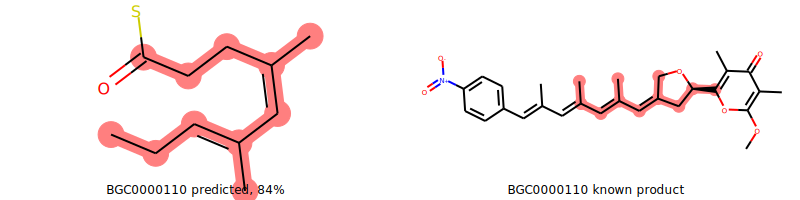

(1/67): BGC0000978 Cylindrospermopsin biosynthetic gene cluster
	Starter unit from antiSMASH: mal
	Starter from MiBiG: Other
cyrD
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['mal']
cyrF
	Domains: ['KS', 'AT', 'ACP']
	Operations: [<class 'domain.KSAT'>]
	Specificity: ['mal']
cyrB
	Domains: ['KS', 'AT', 'DH', 'cMT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.cMT'>, <class 'domain.DH'>]
	Specificity: ['mal', 'C1']
cyrE
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'B1']
cyrC
	Domains: ['KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mal', 'B1']


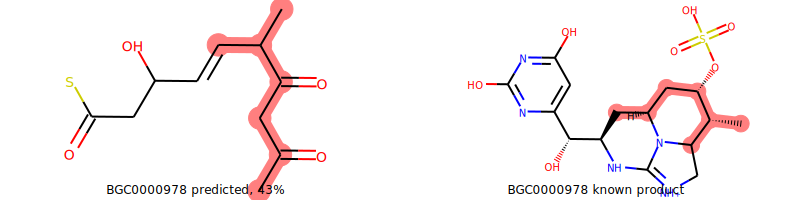

(2/67): BGC0000969 Chondramide biosynthetic gene cluster
	Starter unit from antiSMASH: mmal
	Starter from MiBiG: Acetyl-CoA
cmdA
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['mmal']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mmal', 'U']
cmdB
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>, <class 'domain.ER'>]
	Specificity: ['mmal', 'C2']


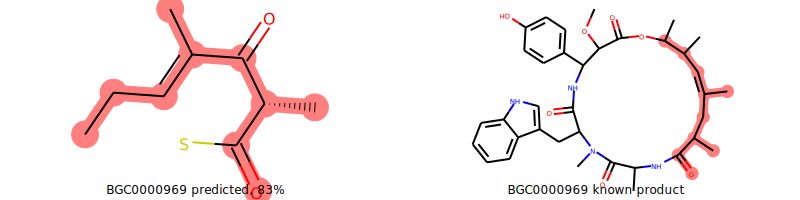

(3/67): BGC0000167 Vicenistatin biosynthetic gene cluster
	Starter unit from antiSMASH: mal
	Starter from MiBiG: Not provided
vinP1
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['mal']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'U']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mmal', 'B1']
vinP2
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>, <class 'domain.ER'>]
	Specificity: ['mmal', 'B1']
vinP3
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'U']
	Domains: ['KS', 'AT', 'KR', 'ACP', 'PKS_Do

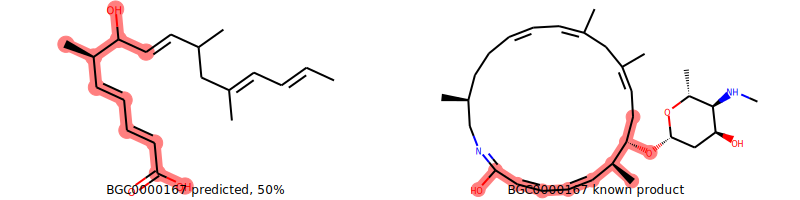

(4/67): BGC0000136 Rifamycin biosynthetic gene cluster
	Starter unit from antiSMASH: mmal
	Starter from MiBiG: Not provided
rifA
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['mmal']
	Domains: ['KS', 'AT', 'ACP']
	Operations: [<class 'domain.KSAT'>]
	Specificity: ['mal']
	Domains: ['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mmal', 'C1']
rifB
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mmal', 'B1']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mmal', 'U']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mmal', 'U']
rifC
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<c

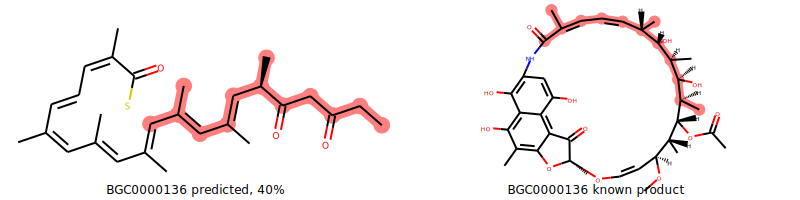

(5/67): BGC0001009 Melithiazol biosynthetic gene cluster
	Starter unit from antiSMASH: isobut
	Starter from MiBiG: Not provided
melB
	Domains: ['KS', 'AT', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['isobut']
melD
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'U']
melE
	Domains: ['KS', 'AT', 'oMT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.oMT'>]
	Specificity: ['mmal', 'A1']
melF
	Domains: ['KS', 'AT', 'oMT', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.oMT'>]
	Specificity: ['mal']


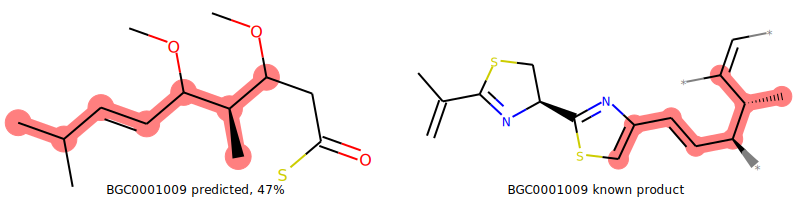

(6/67): BGC0000148 Spinosad biosynthetic gene cluster
	Starter unit from antiSMASH: mmal
	Starter from MiBiG: Not provided
spnA
	Domains: ['KS', 'AT', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['mmal']
	Domains: ['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mal', 'A2']
spnB
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>, <class 'domain.ER'>]
	Specificity: ['mal', 'B1']
spnC
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mmal', 'A1']
	Domains: ['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mal', 'A1']
spnD
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]

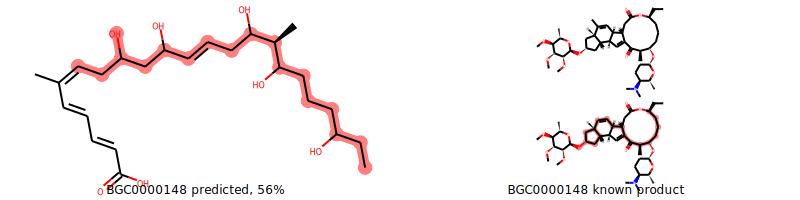

(7/67): BGC0000090 Macbecin biosynthetic gene cluster
	Starter unit from antiSMASH: mmal
	Starter from MiBiG: 3,5-AHBA-CoA
mbcAI
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['mmal']
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>, <class 'domain.ER'>]
	Specificity: ['mxmal', 'B1']
	Domains: ['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mmal', 'A1']
mbcAII
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mmal', 'U']
	Domains: ['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mmal', 'A1']
mbcAIII
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 

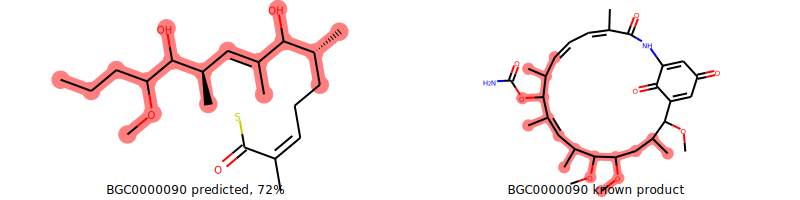

(8/67): BGC0001288 Maklamicin biosynthetic gene cluster
	Starter unit from antiSMASH: mal
	Starter from MiBiG: Not provided
makA1
	Domains: ['KS', 'AT', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['mal']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mmal', 'U']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'U']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mmal', 'B1']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mmal', 'B1']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'U']
makA2
	Domains: 

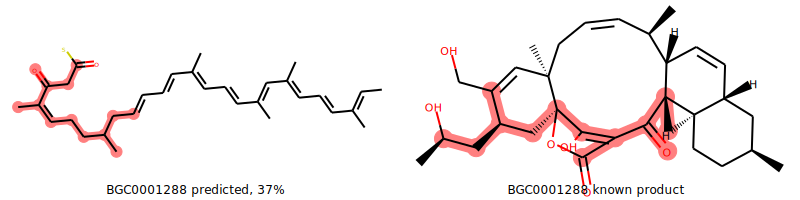

(9/67): BGC0001024 Myxothiazol biosynthetic gene cluster
	Starter unit from antiSMASH: mal
	Starter from MiBiG: 3-Methylbutyryl-CoA
mtaB
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['mal']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mmal', 'B1']
mtaD
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'U']
mtaE
	Domains: ['KS', 'AT', 'oMT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.oMT'>]
	Specificity: ['mmal', 'A1']
mtaF
	Domains: ['KS', 'AT', 'oMT', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.oMT'>]
	Specificity: ['mal']


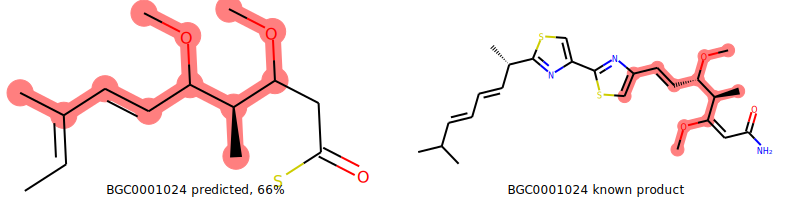

(10/67): BGC0001046 Streptolydigin biosynthetic gene cluster
	Starter unit from antiSMASH: mal
	Starter from MiBiG: Acetyl-CoA
slgA1
	Domains: ['KS', 'AT', 'DH', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['mal']
	Domains: ['KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mmal', 'C1']
	Domains: ['KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mal', 'B1']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mmal', 'B1']
slgA2
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mmal', 'A2']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mmal', 'B1']
slgA3
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operatio

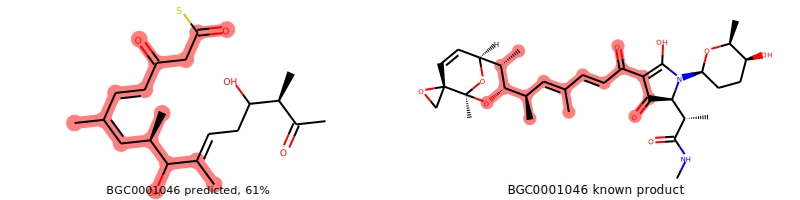

(11/67): BGC0000023 Aurafuron biosynthetic gene cluster
	Starter unit from antiSMASH: mmal
	Starter from MiBiG: 3-Methylbutyryl-CoA
aufC
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['mmal']
aufD
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mmal', 'U']
	Domains: ['KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mal', 'U']
aufE
	Domains: ['KS', 'AT', 'ER', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.ER'>]
	Specificity: ['mxmal', 'C1']
aufF
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'B1']
	Domains: ['KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mmal', 'C1']
aufG
	Domains: ['KS', 'AT', 'DH', 'ER', 'ACP']
	Operat

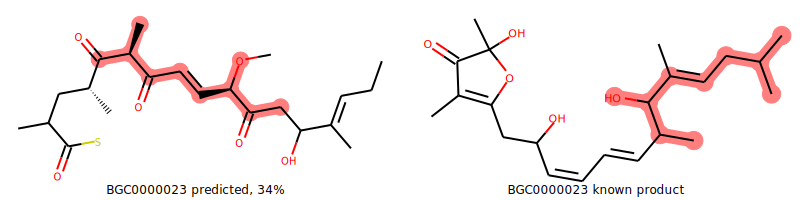

(12/67): BGC0000072 Gulmirecin biosynthetic gene cluster
	Starter unit from antiSMASH: mmal
	Starter from MiBiG: Acetyl-CoA
gulA
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['mmal']
gulB
	Domains: ['KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mal', 'A1']
gulC
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mmal', 'B1']
gulD
	Domains: ['KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mal', 'U']
gulE
	Domains: ['KS', 'AT', 'ACP']
	Operations: [<class 'domain.KSAT'>]
	Specificity: ['mal']
gulF
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'Thioesterase']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>, <class 'domain.ER'>, <class 'domain.TE'>]
	Specificity: ['mmal', 'U']


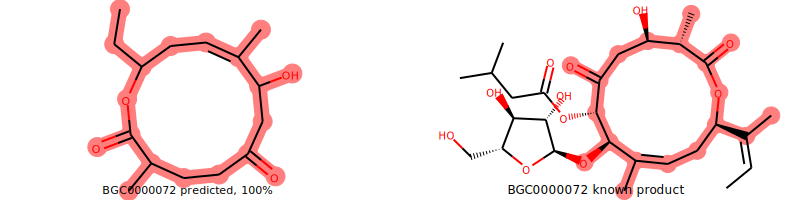

(13/67): BGC0000079 Indanomycin biosynthetic gene cluster
	Starter unit from antiSMASH: mal
	Starter from MiBiG: Not provided
idmL
	Domains: ['KS', 'AT', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['mal']
	Domains: ['KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mal', 'A1']
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>, <class 'domain.ER'>]
	Specificity: ['emal', 'U']
idmM
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'B1']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'B1']
idmN
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity

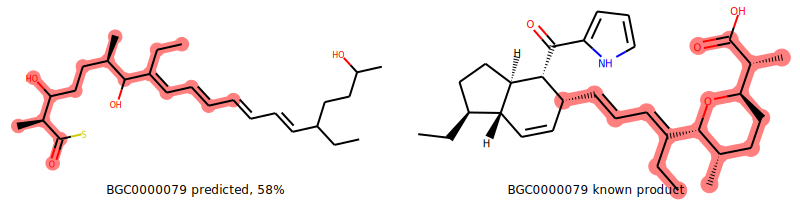

(14/67): BGC0000981 Cylindrospermopsin biosynthetic gene cluster
	Starter unit from antiSMASH: mal
	Starter from MiBiG: Not provided
cyrB
	Domains: ['KS', 'AT', 'DH', 'cMT', 'KR', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['mal']
cyrC
	Domains: ['KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mal', 'B1']
cyrD
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'B1']
cyrE
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'B1']
cyrF
	Domains: ['KS', 'AT', 'ACP']
	Operations: [<class 'domain.KSAT'>]
	Specificity: ['mal']


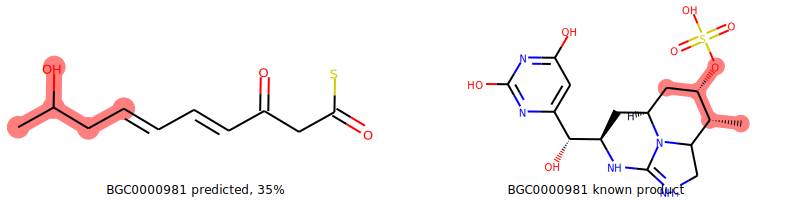

(15/67): BGC0001172 Chlorizidine A biosynthetic gene cluster
	Starter unit from antiSMASH: mal
	Starter from MiBiG: Other
clz6
	Domains: ['KS', 'AT', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['mal']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mmal', 'C1']
clz7
	Domains: ['KS', 'AT', 'ACP']
	Operations: [<class 'domain.KSAT'>]
	Specificity: ['mal']


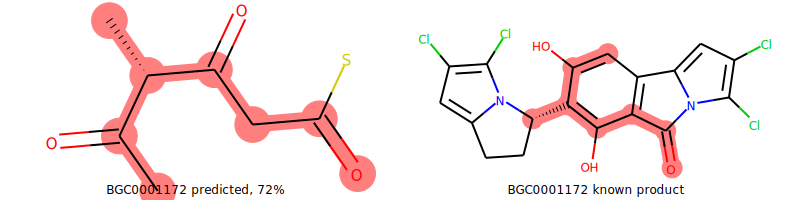

(16/67): BGC0000054 Erythromycin biosynthetic gene cluster
	Starter unit from antiSMASH: prop
	Starter from MiBiG: Not provided
eryAI
	Domains: ['AT', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['prop']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mmal', 'B2']
	Domains: ['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mmal', 'A1']
eryAII
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mmal', 'C2']
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>, <class 'domain.ER'>]
	Specificity: ['mmal', 'U']
eryAIII
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mmal', 'A1']
	Domains: 

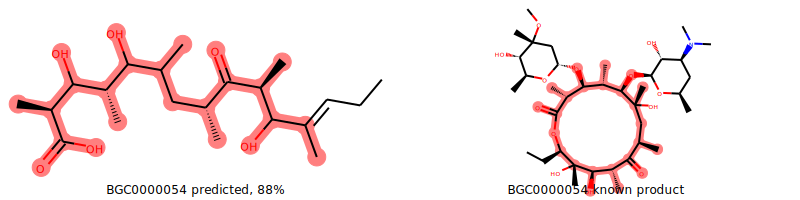

(17/67): BGC0000116 Nystatin-like Pseudonocardia polyene biosynthetic gene cluster
	Starter unit from antiSMASH: mal
	Starter from MiBiG: Not provided
cppA
	Domains: ['KS', 'AT', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['mal']
cppB
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mmal', 'A2']
	Domains: ['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mmal', 'A1']
cppC
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'U']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'B1']
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>, <class 'domai

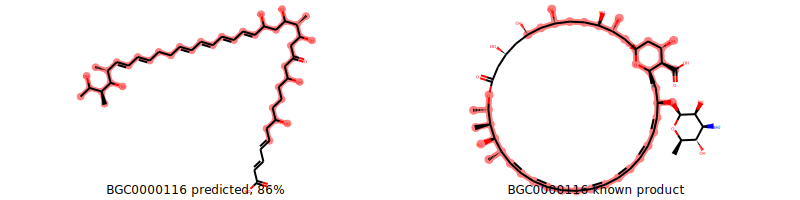

(18/67): BGC0000034 Candicidin biosynthetic gene cluster
	Starter unit from antiSMASH: mal
	Starter from MiBiG: Not provided
fscA
	Domains: ['KS', 'AT', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['mal']
fscB
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mmal', 'B1']
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>, <class 'domain.ER'>]
	Specificity: ['mmal', 'B1']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mmal', 'B1']
fscC
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'B1']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'do

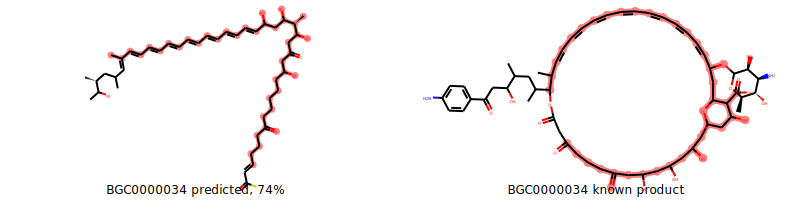

(19/67): BGC0000001 Abyssomicin biosynthetic gene cluster
	Starter unit from antiSMASH: mal
	Starter from MiBiG: Acetyl-CoA
abyB1
	Domains: ['KS', 'AT', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['mal']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'U']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'B1']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'U']
abyB2
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mmal', 'C1']
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>, <class 'domain.ER'>]
	Specificity

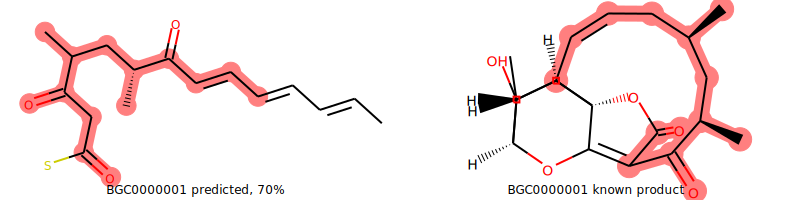

(20/67): BGC0000069 Gephyronic acid biosynthetic gene cluster
	Starter unit from antiSMASH: mal
	Starter from MiBiG: Not provided
gphG
	Domains: ['KS', 'AT', 'cMT', 'KR', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['mal']
gphH
	Domains: ['KS', 'AT', 'cMT', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.cMT'>]
	Specificity: ['mal']
gphI
	Domains: ['KS', 'AT', 'DH', 'cMT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.cMT'>, <class 'domain.DH'>]
	Specificity: ['mal', 'U']
gphJ
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP', 'Thioesterase']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>, <class 'domain.TE'>]
	Specificity: ['mal', 'U']


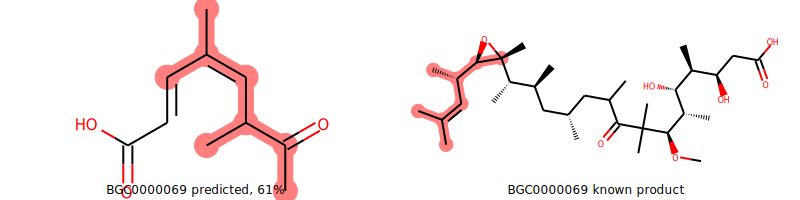

(21/67): BGC0000380 Leupyrrin biosynthetic gene cluster
	Starter unit from antiSMASH: mal
	Starter from MiBiG: Other
leuA
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['mal']
leuB
	Domains: ['KS', 'AT', 'DH', 'cMT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.cMT'>, <class 'domain.DH'>]
	Specificity: ['mal', 'C1']
leuD
	Domains: ['KS', 'AT', 'DH', 'cMT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.cMT'>, <class 'domain.DH'>]
	Specificity: ['mal', 'C1']


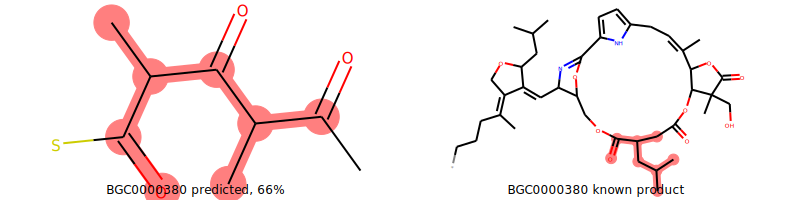

(22/67): BGC0000059 Filipin biosynthetic gene cluster
	Starter unit from antiSMASH: mal
	Starter from MiBiG: Not provided
pteA1
	Domains: ['KS', 'AT', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['mal']
	Domains: ['KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mal', 'B1']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'B1']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'B1']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'U']
pteA2
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'B1']
	Domains: ['KS', 'A

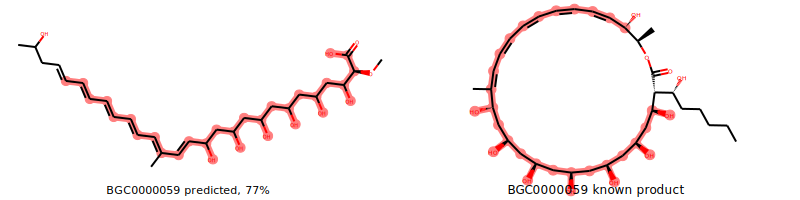

(23/67): BGC0000991 Epothilone biosynthetic gene cluster
	Starter unit from antiSMASH: mal
	Starter from MiBiG: Not provided
epoA
	Domains: ['KS', 'AT', 'ER', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['mal']
epoC
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mmal', 'B1']
epoD
	Domains: ['KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mal', 'B1']
	Domains: ['KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mal', 'A1']
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>, <class 'domain.ER'>]
	Specificity: ['mal', 'B1']
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>, <class 'domain.ER'>]
	Specificity: ['mmal', 'B1']
epoE
	Domains: ['KS

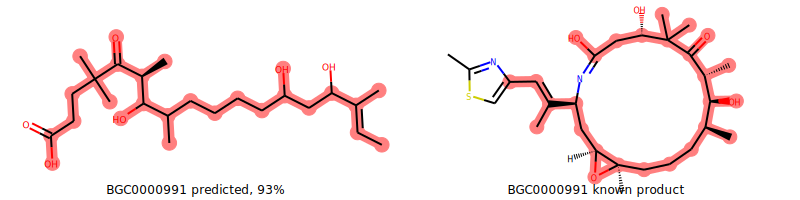

(24/67): BGC0001040 Rapamycin biosynthetic gene cluster
	Starter unit from antiSMASH: mmal
	Starter from MiBiG: Not provided
rapA
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['mmal']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'U']
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>, <class 'domain.ER'>]
	Specificity: ['mmal', 'B1']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mmal', 'B1']
rapB
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'U']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain

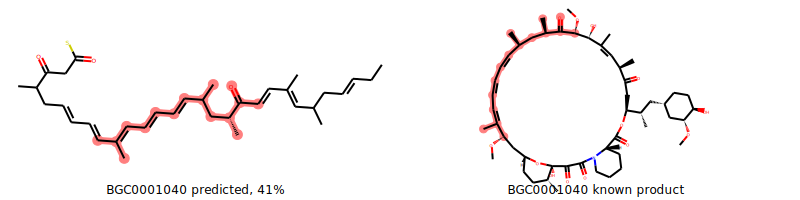

(25/67): BGC0000103 Mycolactone biosynthetic gene cluster
	Starter unit from antiSMASH: mal
	Starter from MiBiG: Not provided
mlsA1
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['mal']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'U']
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>, <class 'domain.ER'>]
	Specificity: ['mmal', 'U']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mmal', 'U']
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>, <class 'domain.ER'>]
	Specificity: ['mmal', 'U']
	Domains: ['KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mal', 'A1

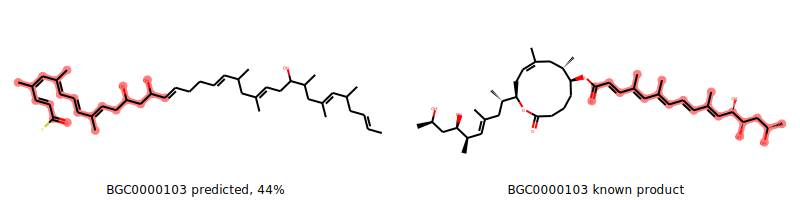

(26/67): BGC0000159 Tautomycin biosynthetic gene cluster
	Starter unit from antiSMASH: isobut
	Starter from MiBiG: Isobutyryl-CoA
ttmJ
	Domains: ['AT', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['isobut']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mxmal', 'B1']
	Domains: ['KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mal', 'A1']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mmal', 'C1']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'U']
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>, <class 'domain.ER'>]
	Specificity: ['mmal', 'U']
	Domains: ['KS', 'AT', 'KR', 'ACP

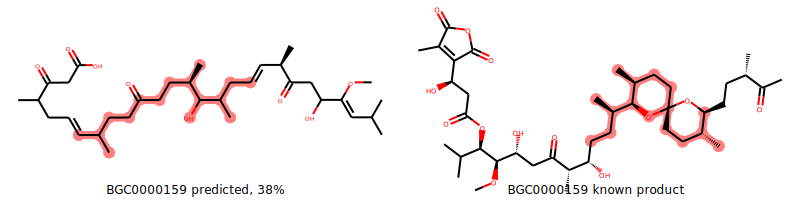

(27/67): BGC0000032 Calcimycin biosynthetic gene cluster
	Starter unit from antiSMASH: mmal
	Starter from MiBiG: Not provided
SchA1
	Domains: ['KS', 'AT', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['mmal']
	Domains: ['KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mmal', 'U']
SchA2
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>, <class 'domain.ER'>]
	Specificity: ['mmal', 'B1']
SchA4
	Domains: ['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mal', 'A1']
SchA5
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'C1']
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <

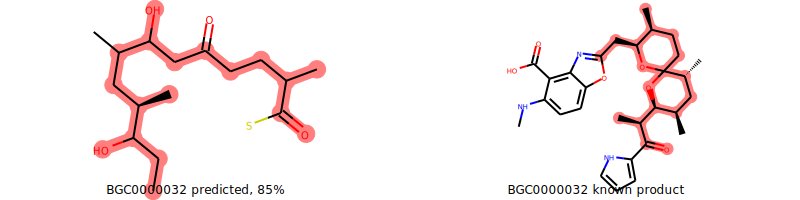

(28/67): BGC0000094 Methymycin / pikromycin biosynthetic gene cluster
	Starter unit from antiSMASH: mmal
	Starter from MiBiG: Malonyl-CoA
pikAI
	Domains: ['KS', 'AT', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['mmal']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mmal', 'B2']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'U']
pikAII
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mmal', 'C2']
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>, <class 'domain.ER'>]
	Specificity: ['mmal', 'U']
pikAIII
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>

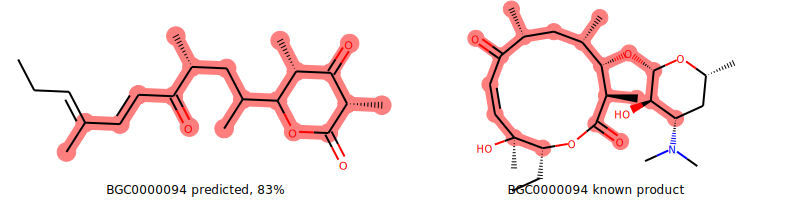

(29/67): BGC0000085 Lankamycin biosynthetic gene cluster
	Starter unit from antiSMASH: 2metbut
	Starter from MiBiG: Not provided
lkmAI
	Domains: ['AT', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['2metbut']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mmal', 'B2']
	Domains: ['KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mmal', 'A1']
lkmAII
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mmal', 'C2']
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>, <class 'domain.ER'>]
	Specificity: ['mmal', 'U']
lkmAIII
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mmal', 'A1']
	Domai

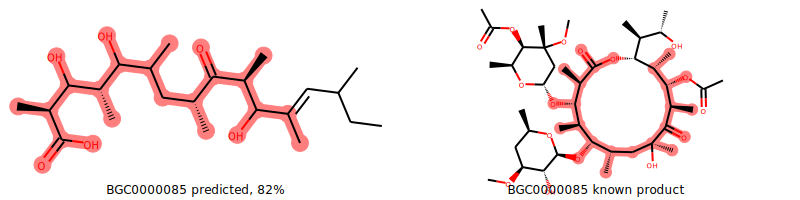

(30/67): BGC0000113 Niddamycin biosynthetic gene cluster
	Starter unit from antiSMASH: mal
	Starter from MiBiG: Not provided
nidA1
	Domains: ['KS', 'AT', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['mal']
	Domains: ['KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mal', 'B1']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'B1']
nidA2
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'B1']
nidA3
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mmal', 'C2']
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.

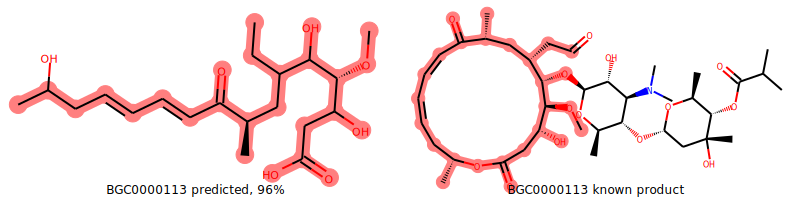

(31/67): BGC0000080 Jerangolid biosynthetic gene cluster
	Starter unit from antiSMASH: mmal
	Starter from MiBiG: Not provided
jerA
	Domains: ['KS', 'AT', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['mmal']
jerB
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mmal', 'U']
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>, <class 'domain.ER'>]
	Specificity: ['mal', 'B1']
jerC
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mmal', 'B1']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'U']
jerD
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class

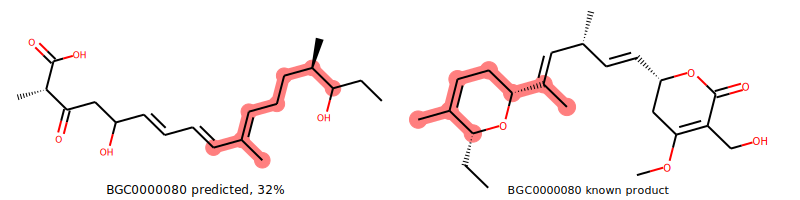

(32/67): BGC0000092 Megalomicin biosynthetic gene cluster
	Starter unit from antiSMASH: prop
	Starter from MiBiG: Not provided
megAI
	Domains: ['AT', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['prop']
	Domains: ['KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mmal', 'B2']
	Domains: ['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mmal', 'A1']
megAII
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mmal', 'C2']
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>, <class 'domain.ER'>]
	Specificity: ['mmal', 'U']
megAIII
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mmal', 'A1']
	Domains: ['KS', 

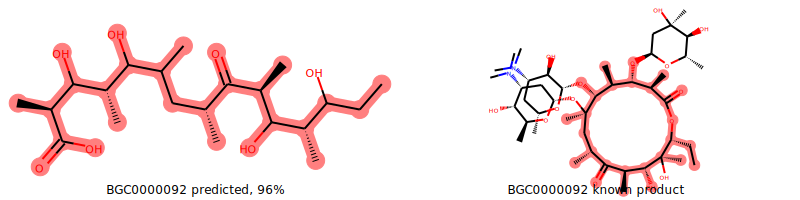

(33/67): BGC0000990 Epothilone biosynthetic gene cluster
	Starter unit from antiSMASH: mal
	Starter from MiBiG: Not provided
epoA
	Domains: ['KS', 'AT', 'ER', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['mal']
epoC
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mmal', 'B1']
epoD
	Domains: ['KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mal', 'B1']
	Domains: ['KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mal', 'A1']
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>, <class 'domain.ER'>]
	Specificity: ['mal', 'B1']
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>, <class 'domain.ER'>]
	Specificity: ['mmal', 'B1']
epoE
	Domains: ['KS

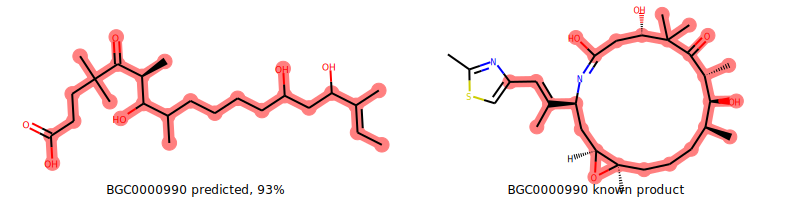

(34/67): BGC0001011 Meridamycin biosynthetic gene cluster
	Starter unit from antiSMASH: mal
	Starter from MiBiG: Not provided
merA
	Domains: ['KS', 'AT', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['mal']
	Domains: ['KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mmal', 'A1']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mmal', 'U']
	Domains: ['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mal', 'B1']
merB
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mxmal', 'B1']
	Domains: ['KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mmal', 'C2']
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	Operations: [<cla

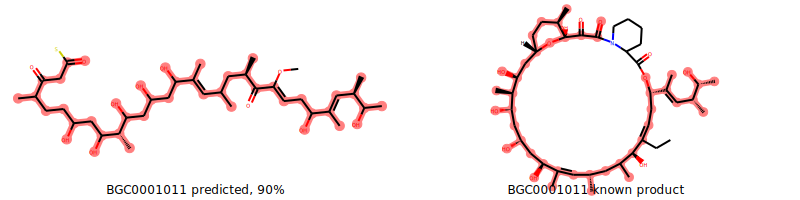

(35/67): BGC0000108 Natamycin biosynthetic gene cluster
	Starter unit from antiSMASH: mal
	Starter from MiBiG: Not provided
scnS0
	Domains: ['KS', 'AT', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['mal']
scnS1
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mal', 'B1']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'B1']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'B1']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'B1']
scnS2
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['m

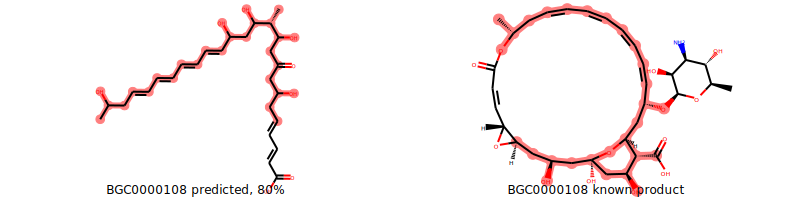

(36/67): BGC0000066 Geldanamycin biosynthetic gene cluster
	Starter unit from antiSMASH: mmal
	Starter from MiBiG: Not provided
gdmAI
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['mmal']
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>, <class 'domain.ER'>]
	Specificity: ['mxmal', 'U']
	Domains: ['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mmal', 'A1']
gdmAII
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mmal', 'B1']
	Domains: ['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mxmal', 'A1']
gdmAIII
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <

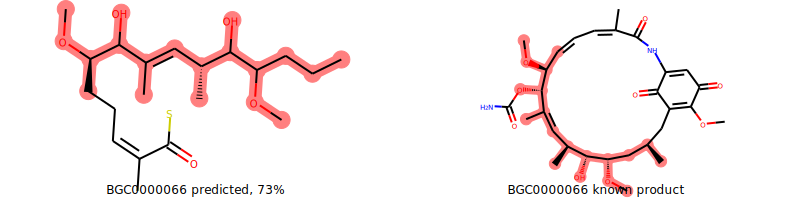

(37/67): BGC0000153 Stigmatellin biosynthetic gene cluster
	Starter unit from antiSMASH: mmal
	Starter from MiBiG: Acetyl-CoA
stiA
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['mmal']
stiB
	Domains: ['KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mal', 'B1']
stiC
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'U']
stiD
	Domains: ['KS', 'AT', 'oMT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.oMT'>]
	Specificity: ['mmal', 'U']
stiE
	Domains: ['KS', 'AT', 'oMT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.oMT'>]
	Specificity: ['mmal', 'C2']
stiF
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>, <class 'domain.ER'>]
	Specificity: ['mal', 

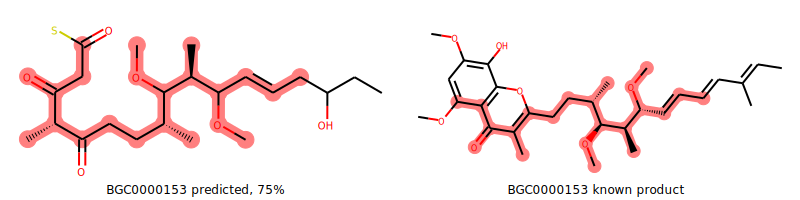

(38/67): BGC0001342 Thuggacin biosynthetic gene cluster
	Starter unit from antiSMASH: mmal
	Starter from MiBiG: Not provided
tugA
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['mmal']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mmal', 'B1']
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>, <class 'domain.ER'>]
	Specificity: ['mmal', 'B1']
tugB
	Domains: ['KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mal', 'B1']
	Domains: ['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mal', 'B1']
tugC
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mal', 'A1']
	Do

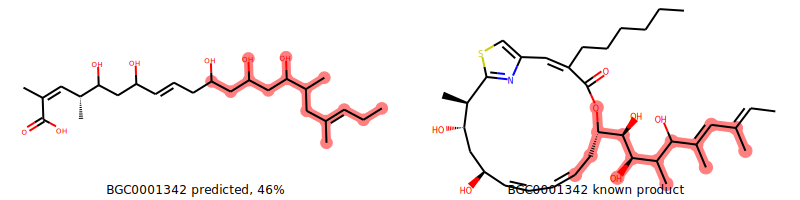

(39/67): BGC0000109 Nemadectin biosynthetic gene cluster
	Starter unit from antiSMASH: 2metbut
	Starter from MiBiG: Not provided
nemA1-1
	Domains: ['AT', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['2metbut']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mmal', 'B1']
nemA1-2
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mmal', 'B1']
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>, <class 'domain.ER'>]
	Specificity: ['mal', 'B1']
nemA2
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'ACP']
	Operations: [<class 'domain.KSAT'>]
	Specificity: ['mal']
	Domains: ['KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mal', 'B1']
	Domains: ['KS', 'A

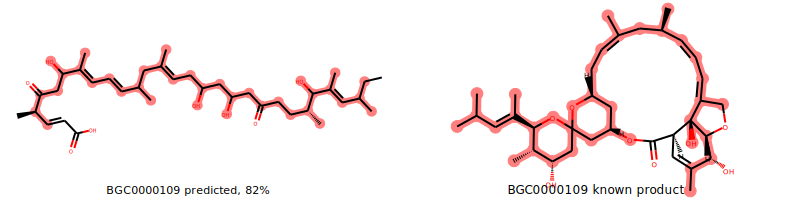

(40/67): BGC0000989 Epothilone biosynthetic gene cluster
	Starter unit from antiSMASH: mal
	Starter from MiBiG: Not provided
epoA
	Domains: ['KS', 'AT', 'ER', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['mal']
epoB
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mmal', 'B1']
epoC
	Domains: ['KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mal', 'B1']
	Domains: ['KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mal', 'A1']
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>, <class 'domain.ER'>]
	Specificity: ['mal', 'B1']
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>, <class 'domain.ER'>]
	Specificity: ['mmal', 'B1']
epoD
	Domains: ['KS

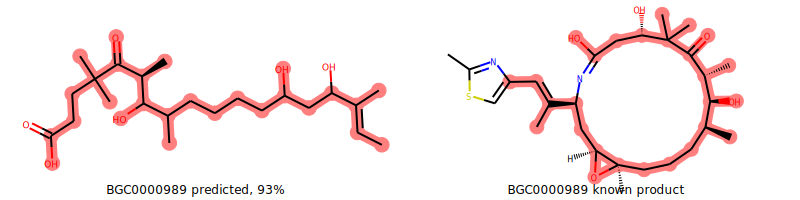

(41/67): BGC0001010 Melithiazol biosynthetic gene cluster
	Starter unit from antiSMASH: isobut
	Starter from MiBiG: Isobutyryl-CoA
melB
	Domains: ['KS', 'AT', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['isobut']
melD
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'U']
melE
	Domains: ['KS', 'AT', 'oMT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.oMT'>]
	Specificity: ['mmal', 'A1']
melF
	Domains: ['KS', 'AT', 'oMT', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.oMT'>]
	Specificity: ['mal']


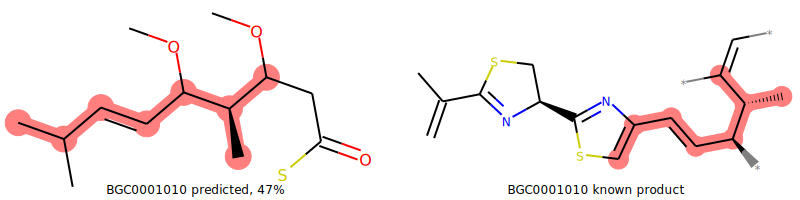

(42/67): BGC0000086 Lasalocid biosynthetic gene cluster
	Starter unit from antiSMASH: mal
	Starter from MiBiG: Not provided
lsd11
	Domains: ['KS', 'AT', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['mal']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['emal', 'B1']
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>, <class 'domain.ER'>]
	Specificity: ['mal', 'B1']
lsd12
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['emal', 'U']
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>, <class 'domain.ER'>]
	Specificity: ['mmal', 'B1']
	Domains: ['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'd

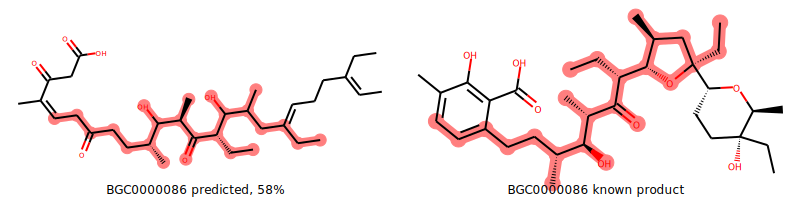

(43/67): BGC0000988 Epothilone biosynthetic gene cluster
	Starter unit from antiSMASH: mal
	Starter from MiBiG: Not provided
epoA
	Domains: ['KS', 'AT', 'ER', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['mal']
epoB
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mmal', 'B1']
epoC
	Domains: ['KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mal', 'B1']
	Domains: ['KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mal', 'A1']
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>, <class 'domain.ER'>]
	Specificity: ['mal', 'B1']
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>, <class 'domain.ER'>]
	Specificity: ['mmal', 'B1']
epoD
	Domains: ['KS

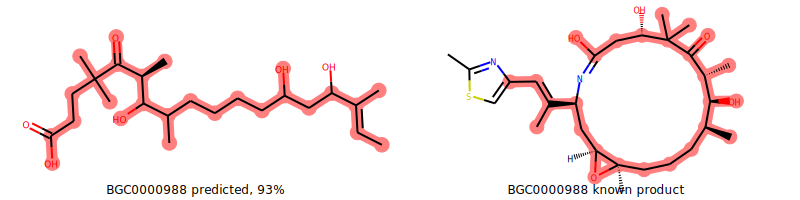

(44/67): BGC0000035 Chalcomycin biosynthetic gene cluster
	Starter unit from antiSMASH: mal
	Starter from MiBiG: Not provided
chmGI
	Domains: ['KS', 'AT', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['mal']
	Domains: ['KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mmal', 'U']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'B1']
chmGII
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'B1']
chmGIII
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mmal', 'C2']
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <clas

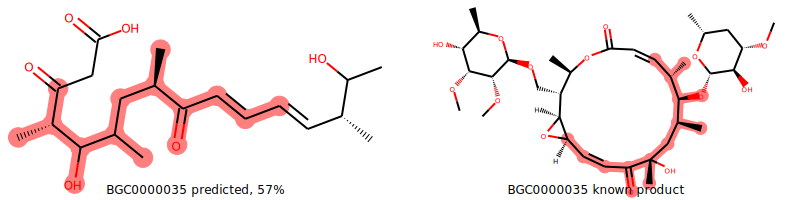

(45/67): BGC0001003 Lipomycin biosynthetic gene cluster
	Starter unit from antiSMASH: isobut
	Starter from MiBiG: Isobutyryl-CoA
lipPks1
	Domains: ['AT', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['isobut']
	Domains: ['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mmal', 'A2']
lipPks2
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mmal', 'B1']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'B1']
lipPks3
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'B1']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 

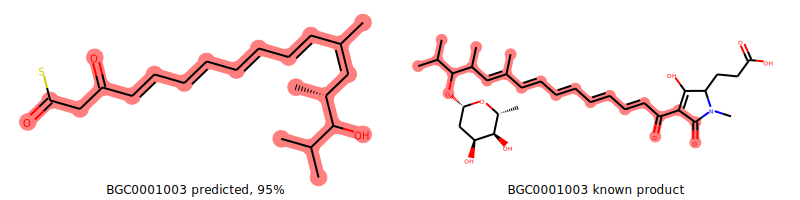

(46/67): BGC0000014 Ambruticin biosynthetic gene cluster
	Starter unit from antiSMASH: mmal
	Starter from MiBiG: Not provided
ambA
	Domains: ['KS', 'AT', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['mmal']
ambB
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mmal', 'U']
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>, <class 'domain.ER'>]
	Specificity: ['mal', 'B1']
ambC
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mmal', 'B1']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'U']
ambD
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class

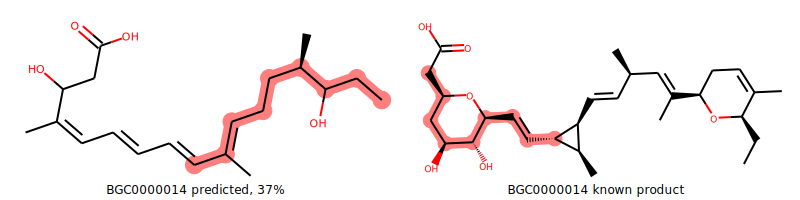

(47/67): BGC0001012 Meridamycin biosynthetic gene cluster
	Starter unit from antiSMASH: mal
	Starter from MiBiG: Not provided
merA
	Domains: ['KS', 'AT', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['mal']
	Domains: ['KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mmal', 'A1']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mmal', 'U']
	Domains: ['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mal', 'B1']
merB
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mxmal', 'B1']
	Domains: ['KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mmal', 'C2']
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	Operations: [<cla

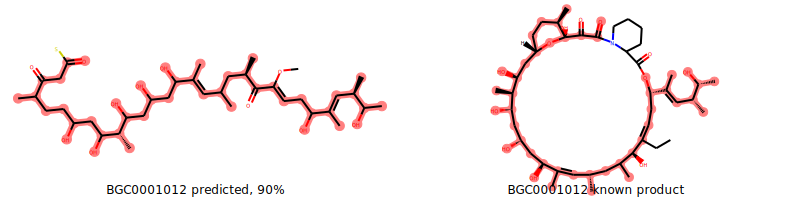

(48/67): BGC0000074 Herbimycin biosynthetic gene cluster
	Starter unit from antiSMASH: mmal
	Starter from MiBiG: Not provided
hbmAI
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['mmal']
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>, <class 'domain.ER'>]
	Specificity: ['mxmal', 'U']
	Domains: ['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mmal', 'A1']
hbmAII
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mmal', 'B1']
	Domains: ['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mxmal', 'A1']
hbmAIII
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <cl

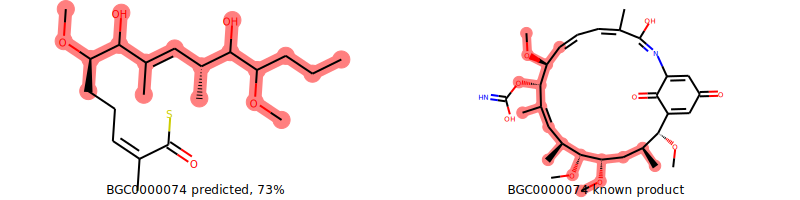

(49/67): BGC0000031 Borrelidin biosynthetic gene cluster
	Starter unit from antiSMASH: trans-1,2-CPDA
	Starter from MiBiG: Trans-cyclopentane-(1R,2R)-dicarboxylic acid
borA1
	Domains: ['AT', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['trans-1,2-CPDA']
borA2
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mal', 'B1']
borA3
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'B1']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mmal', 'B1']
borA4
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mmal', 'A1']
borA5
	Domains: ['PKS_Do

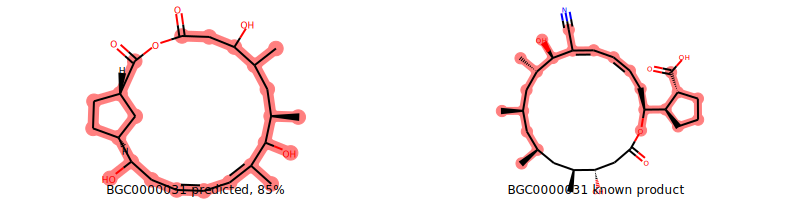

(50/67): BGC0001051 Thuggacin biosynthetic gene cluster
	Starter unit from antiSMASH: mmal
	Starter from MiBiG: Acetyl-CoA
tgaA
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['mmal']
	Domains: ['KS', 'AT', 'DH', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.DH'>]
	Specificity: ['mmal']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mmal', 'B1']
	Domains: ['KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mal', 'B1']
	Domains: ['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mal', 'B1']
tgaB
	Domains: ['KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mmal', 'A1']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'dom

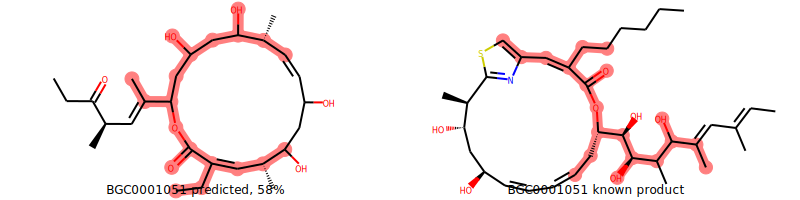

(51/67): BGC0000158 Tautomycetin biosynthetic gene cluster
	Starter unit from antiSMASH: mal
	Starter from MiBiG: Malonyl-CoA
ttnA
	Domains: ['KS', 'AT', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['mal']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mmal', 'B1']
	Domains: ['KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mal', 'A1']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mmal', 'C1']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'U']
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>, <class 'domain.ER'>]
	Specificity: ['mmal', 'U']
ttnB
	Domains: ['KS', 'AT', 'DH', '

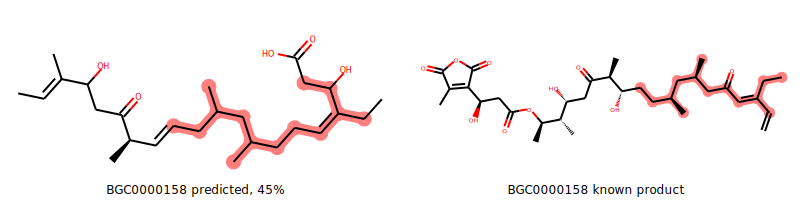

(52/67): BGC0000084 Laidlomycin biosynthetic gene cluster
	Starter unit from antiSMASH: mal
	Starter from MiBiG: Not provided
ladSI
	Domains: ['KS', 'AT', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['mal']
	Domains: ['KS', 'AT', 'DH', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.DH'>]
	Specificity: ['mmal']
ladSII
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>, <class 'domain.ER'>]
	Specificity: ['mmal', 'U']
ladSIII
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'U']
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>, <class 'domain.ER'>]
	Specificity: ['mmal', 'B1']
ladSIV
	Domains: ['PKS_Docking_Nterm', 'KS

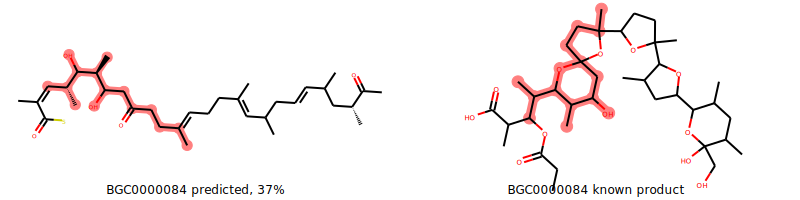

(53/67): BGC0000105 Nanchangmycin biosynthetic gene cluster
	Starter unit from antiSMASH: mal
	Starter from MiBiG: Not provided
nanA1
	Domains: ['KS', 'AT', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['mal']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mmal', 'C1']
nanA11
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>, <class 'domain.ER'>]
	Specificity: ['mmal', 'C2']
nanA2
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>, <class 'domain.ER'>]
	Specificity: ['mmal', 'U']
nanA3
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specific

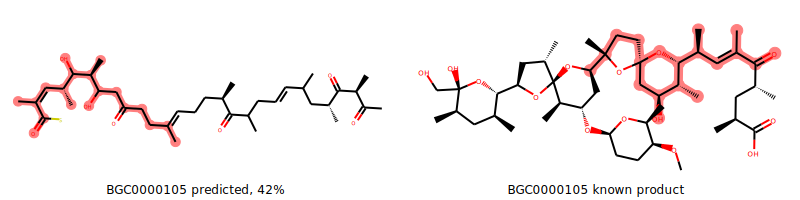

(54/67): BGC0000015 Amphotericin biosynthetic gene cluster
	Starter unit from antiSMASH: mal
	Starter from MiBiG: Not provided
amphA
	Domains: ['KS', 'AT', 'DH', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['mal']
amphB
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mmal', 'A2']
	Domains: ['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mmal', 'A1']
amphC
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'U']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'B1']
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>, <class 'domain.ER'>]
	Specif

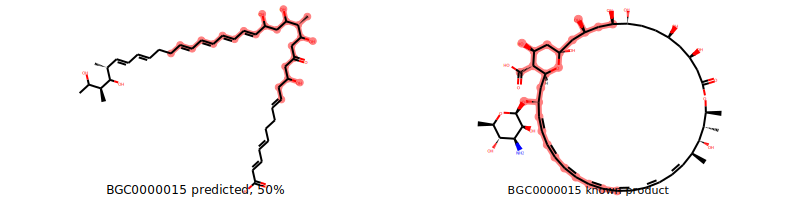

(55/67): BGC0000100 Monensin biosynthetic gene cluster
	Starter unit from antiSMASH: mal
	Starter from MiBiG: Not provided
monAI
	Domains: ['KS', 'AT', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['mal']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mmal', 'C1']
monAII
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>, <class 'domain.ER'>]
	Specificity: ['mmal', 'U']
monAIII
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'U']
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>, <class 'domain.ER'>]
	Specificity: ['mmal', 'B1']
monAIV
	Doma

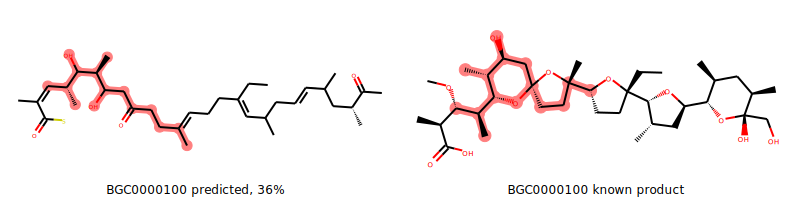

(56/67): BGC0001212 Nannocystin biosynthetic gene cluster
	Starter unit from antiSMASH: mmal
	Starter from MiBiG: Benzoyl-CoA
ncyA
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['mmal']
ncyB
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'U']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mmal', 'B1']
ncyC
	Domains: ['KS', 'AT', 'oMT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.oMT'>]
	Specificity: ['mal', 'U']
ncyD
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mmal', 'B1']


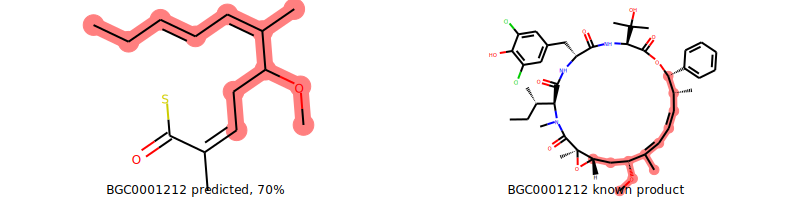

(57/67): BGC0001065 Herboxidiene biosynthetic gene cluster
	Starter unit from antiSMASH: mmal
	Starter from MiBiG: Not provided
herB
	Domains: ['KS', 'AT', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['mmal']
	Domains: ['KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mmal', 'A1']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mmal', 'U']
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>, <class 'domain.ER'>]
	Specificity: ['mmal', 'B1']
herC
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'B1']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mmal', 'B1']
	Dom

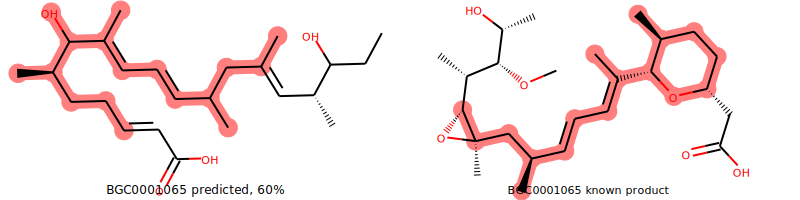

(58/67): BGC0000149 Spirangien biosynthetic gene cluster
	Starter unit from antiSMASH: mmal
	Starter from MiBiG: Acetyl-CoA
spiD
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['mmal']
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>, <class 'domain.ER'>]
	Specificity: ['mmal', 'B1']
spiE
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mmal', 'A1']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mmal', 'U']
spiF
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'A1']
spiG
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	Operations: [<c

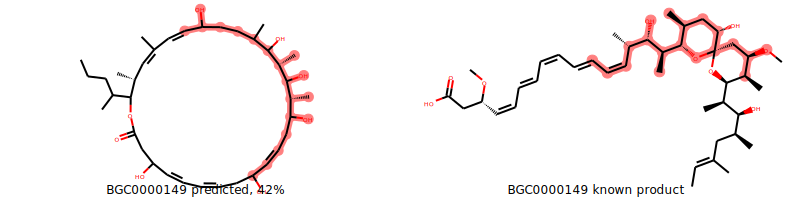

(59/67): BGC0000087 Lasalocid biosynthetic gene cluster
	Starter unit from antiSMASH: mal
	Starter from MiBiG: Not provided
lasAI
	Domains: ['KS', 'AT', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['mal']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['emal', 'B1']
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>, <class 'domain.ER'>]
	Specificity: ['mal', 'B1']
lasAII
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['emal', 'U']
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>, <class 'domain.ER'>]
	Specificity: ['mmal', 'B1']
	Domains: ['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'do

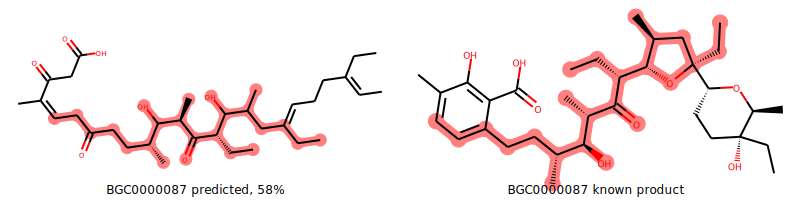

(60/67): BGC0000144 Salinomycin biosynthetic gene cluster
	Starter unit from antiSMASH: mal
	Starter from MiBiG: Malonyl-CoA
slnA1
	Domains: ['KS', 'AT', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['mal']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['emal', 'B1']
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>, <class 'domain.ER'>]
	Specificity: ['mal', 'B1']
slnA2
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mmal', 'B1']
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>, <class 'domain.ER'>]
	Specificity: ['mal', 'B1']
slnA3
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'ACP']
	Op

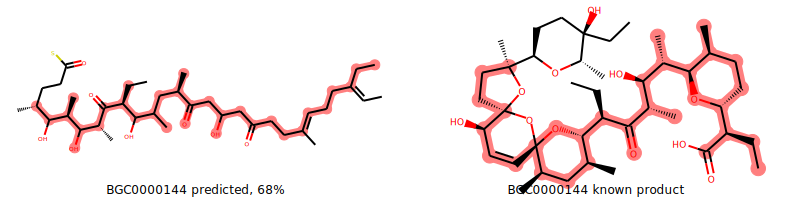

(61/67): BGC0000038 Coelimycin biosynthetic gene cluster
	Starter unit from antiSMASH: mal
	Starter from MiBiG: Malonyl-CoA
SCO6275
	Domains: ['KS', 'AT', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['mal']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'B1']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'B1']
SCO6274
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'B1']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'U']
SCO6273
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class

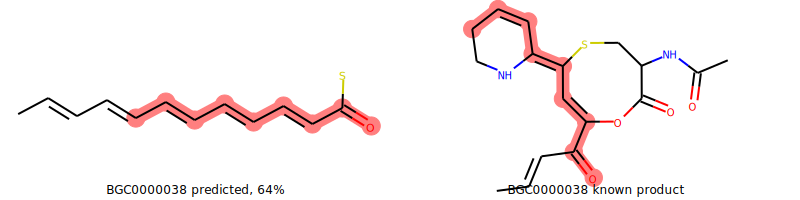

(62/67): BGC0000115 Nystatin biosynthetic gene cluster
	Starter unit from antiSMASH: mal
	Starter from MiBiG: Malonyl-CoA
nysA
	Domains: ['KS', 'AT', 'DH', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['mal']
nysB
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mmal', 'A2']
	Domains: ['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mmal', 'A1']
nysC
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'U']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'B1']
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>, <class 'domain.ER'>]
	Specificity: [

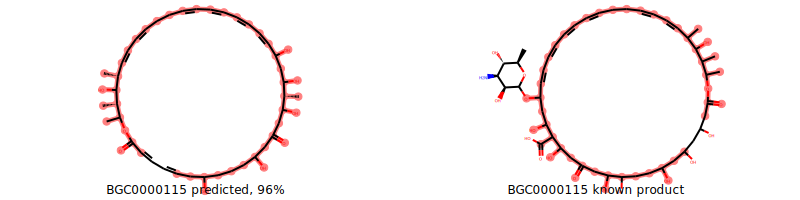

(63/67): BGC0000166 Tylactone biosynthetic gene cluster
	Starter unit from antiSMASH: mmal
	Starter from MiBiG: Not provided
tylG
	Domains: ['KS', 'AT', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['mmal']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mmal', 'B1']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mmal', 'B1']
tylG_1
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'B1']
tylG_2
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mmal', 'C2']
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <clas

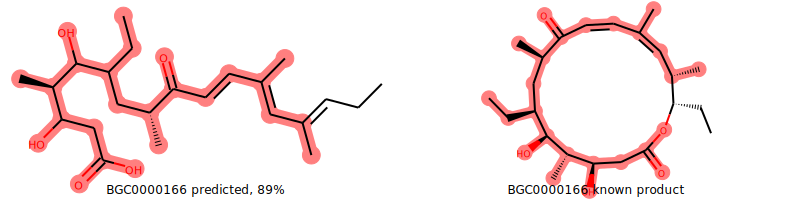

(64/67): BGC0000125 Pimaricin biosynthetic gene cluster
	Starter unit from antiSMASH: mal
	Starter from MiBiG: Not provided
pimS0
	Domains: ['KS', 'AT', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['mal']
pimS1
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mal', 'B1']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'B1']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'B1']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'B1']
pimS2
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['m

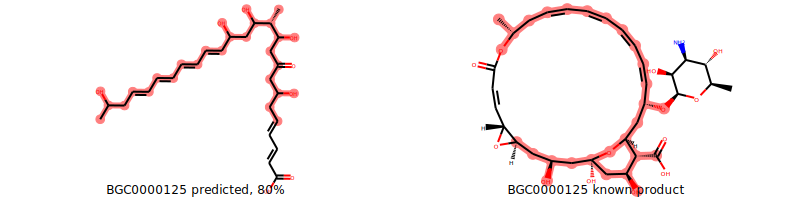

(65/67): BGC0001359 PM100117 / PM100118 biosynthetic gene cluster
	Starter unit from antiSMASH: mmal
	Starter from MiBiG: Not provided
gonP1
	Domains: ['KS', 'AT', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['mmal']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mmal', 'A2']
	Domains: ['KS', 'AT', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mmal', 'A1']
gonP2
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mmal', 'A2']
	Domains: ['KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mmal', 'B1']
	Domains: ['KS', 'AT', 'DH', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>]
	Specificity: ['mal', 'B1']
gonP3
	Domains: ['PKS_Docking_Nte

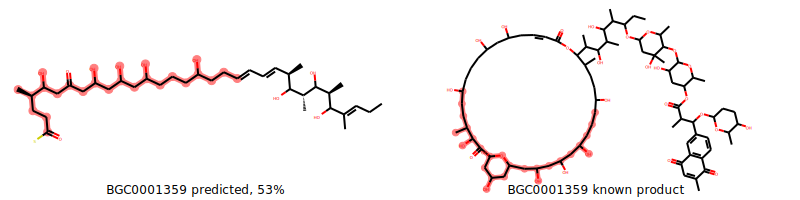

(66/67): BGC0000055 Erythromycin biosynthetic gene cluster
	Starter unit from antiSMASH: prop
	Starter from MiBiG: Propionyl-CoA
eryAI
	Domains: ['AT', 'ACP']
	Operations: [<class 'domain.ATL'>]
	Specificity: ['prop']
	Domains: ['KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mmal', 'B2']
	Domains: ['KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mmal', 'A1']
eryAII
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mmal', 'C2']
	Domains: ['KS', 'AT', 'DH', 'ER', 'KR', 'ACP', 'PKS_Docking_Cterm']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>, <class 'domain.DH'>, <class 'domain.ER'>]
	Specificity: ['mmal', 'U']
eryAIII
	Domains: ['PKS_Docking_Nterm', 'KS', 'AT', 'KR', 'ACP']
	Operations: [<class 'domain.KSAT'>, <class 'domain.KR'>]
	Specificity: ['mmal', 'A1']
	Domains: ['KS', 'AT', 'KR', 'ACP', 

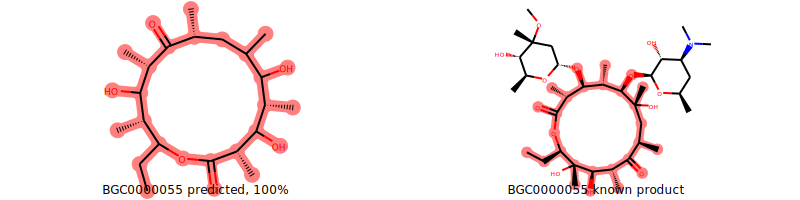

In [19]:
# Iterate over intersection list and show output
nclusters = len(geneClusterIntersect)
for iaccession,accession in enumerate(geneClusterIntersect):
    # Get cluster from cluster dictionary using accession number
    cluster = clusters[accession]
    print('(%d/%d): %s %s' %(iaccession, nclusters, accession, cluster.description))
    print('\tStarter unit from antiSMASH: %s' %(list(cluster.subunits.values())[0].modules[0].operations[0].starter_name))
    with open(os.path.join('./mibig', accession + '.json')) as json_file:            
            mibig_data = json.load(json_file)
            try:
                mibig_starter = mibig_data['general_params']['Polyketide']['starter_unit']
            except KeyError:
                mibig_starter = 'Not provided'
    print('\tStarter from MiBiG: %s' %(mibig_starter))   
    subunits = list(cluster.subunits.values())
    for subunit in subunits:
        print(subunit.name)
        for module in subunit.modules:
            print('\tDomains: %s' %(str(list(module.domains.keys()))))
            print('\tOperations: %s' %(str([type(op) for op in list(module.operations)])))
            domain_types = []
            for op in module.operations:
                try:
                    domain_types.append(op.starter_name)
                except Exception:
                    pass
                try:
                    domain_types.append(op.at_type)
                except Exception:
                    pass
                try:
                    domain_types.append(op.kr_type)
                except Exception:
                    pass
            print('\tSpecificity: %s' %(str(domain_types)))
    # Plot predictions alongside known product
    m_im = Draw.MolsToGridImage(structures[2*iaccession:2*iaccession+2], 
                                highlightAtomLists=highlightAtomLists[2*iaccession:2*iaccession+2], 
                                legends=legends[2*iaccession:2*iaccession+2], 
                                molsPerRow=2,
                                subImgSize=(400, 200), 
                                useSVG=True)
    display(m_im)

# Which clusters seem to have errors and where are they? To report an error, please copy and paste the printed information and annotate the error, preferably in a different font color. I can't change the font color here, so I just used a bunch of exclamation marks, and some color tags, but you get the idea. These aren't actually errors, they're just examples of errors one might annotate.